In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import random

# Load Data

In [2]:
# TODO: Load data here.
indexes = pd.read_csv('hw3_Data1/index.txt', delimiter = '\t', header = None)
x = pd.read_csv('hw3_Data1/gene.txt', delimiter = ' ', header = None).to_numpy().T
y = pd.read_csv('hw3_Data1/label.txt', header = None).to_numpy()
y = (y>0).astype(int).reshape(y.shape[0])

In [3]:
print(indexes)

              0       1       2   3         4  \
0      Hsa.3004  H55933  3' UTR   1  203417.0   
1     Hsa.13491  R39465  3' UTR  2a   23933.0   
2     Hsa.13491  R39465  3' UTR  2a   23933.0   
3     Hsa.37254  R85482  3' UTR  2a  180093.0   
4       Hsa.541  U14973    gene   1       NaN   
...         ...     ...     ...  ..       ...   
1995    Hsa.984  M33210    gene   1       NaN   
1996  Hsa.35124  H18490  3' UTR  2a  171840.0   
1997   Hsa.3952  H40891  3' UTR  2a  175983.0   
1998  Hsa.32734  R77780  3' UTR  2a  145300.0   
1999   Hsa.9683  T49647  3' UTR  2a   67762.0   

                                                      5  
0     H.sapiens mRNA for homologue to yeast ribosoma...  
1     EUKARYOTIC INITIATION FACTOR 4A (Oryctolagus c...  
2     EUKARYOTIC INITIATION FACTOR 4A (Oryctolagus c...  
3     SERUM RESPONSE FACTOR (Homo sapiens)          ...  
4     Human ribosomal protein S29 mRNA, complete cds...  
...                                                 ...  
1995 

In [4]:
print(indexes.iloc[4])

0                                              Hsa.541
1                                               U14973
2                                                 gene
3                                                    1
4                                                  NaN
5    Human ribosomal protein S29 mRNA, complete cds...
Name: 4, dtype: object


In [5]:
print(x.shape)

(62, 2000)


In [6]:
print(x)

[[8.5894163e+03 5.4682409e+03 4.2634075e+03 ... 7.5677500e+01
  8.3522500e+01 2.8701250e+01]
 [9.1642537e+03 6.7195295e+03 4.8834487e+03 ... 1.8656750e+02
  4.4472500e+01 1.6773750e+01]
 [3.8257050e+03 6.9703614e+03 5.3699688e+03 ... 4.2656250e+01
  1.6092500e+01 1.5156250e+01]
 ...
 [6.7306250e+03 3.4721250e+03 2.5594625e+03 ... 1.3352125e+02
  9.3098750e+01 7.4325000e+00]
 [6.2346225e+03 4.0053000e+03 3.0936750e+03 ... 1.1820125e+02
  3.2687500e+01 2.3265000e+01]
 [7.4720100e+03 3.6539341e+03 2.7282162e+03 ... 7.7215000e+01
  4.9862500e+01 3.9631250e+01]]


In [7]:
print(y.shape)

(62,)


In [8]:
print(y)

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1]


# Feature ranking : One-by-one Feature Selection

# Use Similarity-Based: Fisher Score (without normalization)

In [9]:
def get_ui(x,i): #data x and index i, ui is the mean of feature i
    target = x[:,i]
    return np.mean(target)

In [10]:
def get_uij_and_varij(x,i,j):
    target = []
    for k in range(62):
        if y[k] == j:
            target.append(x[k,i])
            
    uij = np.mean(target)
    varij = np.var(target)
    return uij,varij

In [11]:
def insert(idx,idx_score,i,i_score):
    output_idx = idx
    output_idx_score = idx_score
    for k in range(len(output_idx)):
        if i_score >= output_idx_score[k]:
            output_idx.insert(k,i)
            output_idx_score.insert(k,i_score)
            break
    return output_idx,output_idx_score

In [12]:
# TODO: Design your score function for feature selection
# ranking_idx = np.linspace(0,1999,2000,dtype=int)
# random.shuffle(ranking_idx)
ranking_idx = [-1]
ranking_idx_score = [-1]
nij = [62-np.count_nonzero(y),np.count_nonzero(y)]
for i in range(2000): #pick ith feature
#     print(i)
    up = 0
    down = 0
    for j in range(2): #class j
        nj = nij[j] 
        uij,varij = get_uij_and_varij(x,i,j)
        ui = get_ui(x,i)
        up += nj*((uij-ui)**2)
        down += nj*varij
    fisher_score = up/down
    ranking_idx,ranking_idx_score = insert(ranking_idx,ranking_idx_score,i,fisher_score)
# TODO: To use the provided evaluation sample code, you need to generate ranking_idx, which is the sorted index of feature

# Feature evaluation

In [13]:
# Use a simple dicision tree with 5-fold validation to evaluate the feature selection result.
# You can try other classifier and hyperparameter.
score_history = []
for m in range(1, 2001, 1): # m = 5,10,15,...,2000 -> m = 1,2,3,...,2000
    # Select Top m feature
    x_subset = x[:, ranking_idx[:m]]

    # Build random forest
    clf = DecisionTreeClassifier(random_state=0)
#     clf = SVC(kernel='rbf', random_state=0) #build SVM

    # Calculate validation score
    scores = cross_val_score(clf, x_subset, y, cv=5)

    # Save the score calculated with m feature
    score_history.append(scores.mean())

# Report best accuracy.
print(f"Max of Decision Tree: {max(score_history)}")
# print(f"Number of features: {np.argmax(score_history)*5+5}")
print(f"Number of features: {np.argmax(score_history)}")

Max of Decision Tree: 0.9038461538461539
Number of features: 67


# Visualization

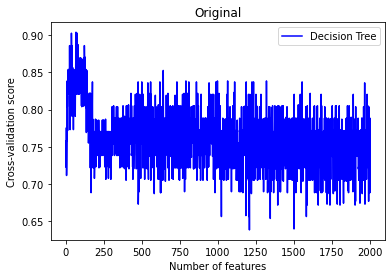

In [14]:
plt.plot(range(1, 2001, 1), score_history, c='blue')
plt.title('Original')
plt.xlabel('Number of features')
plt.ylabel('Cross-validation score')
plt.legend(['Decision Tree'])
plt.savefig('1-3_result.png')

# Record (Max of Decision Tree / Number of features)

completely_random : 0.8538461538461538 / 460

fisher_score = 0.8705128205128204 / 35

fisher_score(skip=1) = 0.9038461538461539 / 67

In [15]:
np.var(x[:,1])

4713963.442321157

In [16]:
np.count_nonzero(y)

22

In [17]:
# print(ranking_idx)

In [18]:
print(ranking_idx_score)

[0.6635444906271158, 0.5524959834149036, 0.5335986349543933, 0.5293435970219149, 0.5158332138357065, 0.4940587102201514, 0.42232326303654544, 0.41350439679544276, 0.3423186424774209, 0.3240600222480309, 0.31585824684282765, 0.29551654414902545, 0.28955924796684723, 0.28212271339787726, 0.2761219499751042, 0.27024293444247527, 0.26803539901513396, 0.2585552620670402, 0.25598450269654033, 0.25332265298021195, 0.2449527394581995, 0.2438741501362598, 0.24161210050056373, 0.23909863641875606, 0.2360358128582009, 0.23470102608950894, 0.2342325142714933, 0.23254760022569748, 0.2321796791781931, 0.231756067583818, 0.23065622336000158, 0.2287377808321727, 0.2271835756880702, 0.22707884629360647, 0.2227299546885926, 0.2218532042011712, 0.22162945933248218, 0.22095958717922784, 0.22085908893459552, 0.217796255843919, 0.21712225726923845, 0.21706213769701663, 0.21484358763432027, 0.2142613819194124, 0.21343690514437402, 0.21335285976657947, 0.21330340803124997, 0.2109090147667673, 0.20867968474035

# Validate mutiple features case

pick index = 248 , 764 , 492 features

In [19]:
import numpy as np
z1 = np.reshape(x[:,248].T,(1,62))
z2 = np.reshape(x[:,764].T,(1,62))
z3 = np.reshape(x[:,492].T,(1,62))
Z = np.concatenate((z1,z2,z3))
print(z1.shape)
print(Z.shape)

(1, 62)
(3, 62)


In [20]:
np.reshape(Z[:,61],(3,1))

array([[2699.1925],
       [ 549.095 ],
       [ 596.045 ]])

# get SB

In [21]:
def cal_uk(Z,k):
    for i in range(62):
        if int(y[i]) == k:
#             print('dfb')
            try:
                target = np.concatenate((target,np.reshape(Z[:,i],(3,1))),axis=1)
            except:
                target = np.reshape(Z[:,i],(3,1))
#     print(target.shape)
#     print(np.average(target,axis=1).shape)
    
    return np.average(target,axis=1)

In [22]:
u0 = np.reshape(cal_uk(Z,0),(3,1))
u1 = np.reshape(cal_uk(Z,1),(3,1))
u = nij[0]*u0 + nij[1]*u1
SB = np.zeros((3,3))
for k in range(2):
    nk = nij[k]
    if k==0:
        uk=u0
    else:
        uk=u1
    SB += nk* np.matmul((uk-u),(uk-u).T)
# print(SB)

# get St

In [23]:
St = np.zeros((3,3))
for i in range(62):
    zi = np.reshape(Z[:,i],(3,1))
    St += np.matmul((zi-u),(zi-u).T)

# get fisher score

In [24]:
score = 0
A = np.matmul(SB,np.linalg.inv(St+1e-2*np.identity(3)))
for i in range(3):
    score += A[i,i]

In [25]:
print(score)

1.0518145839431168


In [26]:
sum([0.6635444906271158,0.5524959834149036, 0.5335986349543933])

1.7496391089964127

# 結論: 故不是score直接相加

In [27]:
a = [2 ,3]
a[:0]

[]

In [28]:
for m in range(1, 2001, 1):
    print(m)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [29]:
for m in range(5, 2001, 5):
    print(m)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
1220

In [30]:
np.argmax(score_history)

67

In [31]:
# print(score_history)
print(score_history[67])

0.9038461538461539
